In [15]:
# Imports
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d  
import matplotlib.animation as animation
from IPython.display import HTML

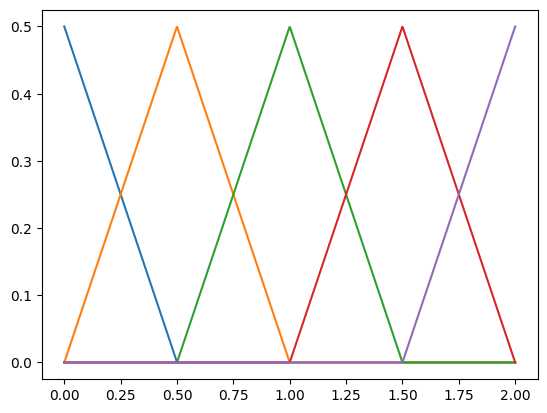

In [16]:
# Hat Functions

def hat(x, shift=0):
    y = np.zeros_like(x)
    mask = np.logical_and(shift <= x, x <= shift + 1)
    y[mask] = 0.5 - abs(0.5 - x[mask] + shift)
    return y

x = np.linspace(0, 2, 1000)

for shift in range(5):
    plt.plot(x, hat(x, shift / 2 - 0.5))


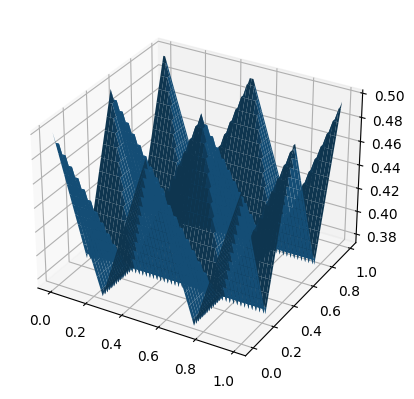

In [17]:
def hat_2d(x, y, shift_x=0, shift_y=0):
    z = np.maximum(0, 1 - np.maximum(abs(x-shift_x), abs(y-shift_y)))/2
    return z

x, y = np.mgrid[0:1:0.01, 0:1:0.01]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

z = np.zeros_like(x)
for shift_x in np.arange(0, 1.5, 0.5):
    for shift_y in np.arange(0, 1.5, 0.5):
        zed = hat_2d(x, y, shift_x, shift_y)
        z = np.maximum(z, zed)

ax.plot_surface(x, y, z)
plt.show()

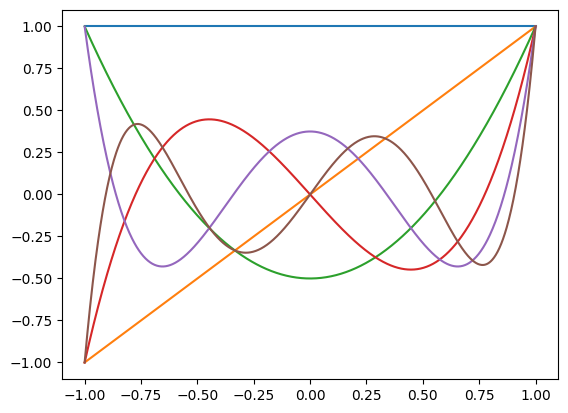

In [18]:
# Legendre Polynomials

# Bonnet's recursion formula
n = 6
P = np.zeros((2, n))
P[0, 0] = P[1, 1] = 1
for i in range(2, n):
    P = np.r_[P, [((2*i - 1)*np.roll(P[-1], 1) - (i-1)*P[-2]) / i]]

# Plot
x = np.linspace(-1, 1, 1000)
y = P @ [x**i for i in range(n)]
plt.plot(np.stack([x]*(n)).T, y.T)
plt.show()

In [19]:
xi, w = scipy.special.roots_legendre(n+1)
xi = [xi**i for i in range(n)]
def inner(Pi, Pj):
    return np.sum((Pi @ xi) * (Pj @ xi) * w)

In [20]:
# Finite element matrix
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(P[i], P[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[ 2.   -0.    0.   -0.    0.   -0.  ]
 [-0.    0.67  0.    0.    0.   -0.  ]
 [ 0.    0.    0.4   0.    0.   -0.  ]
 [-0.    0.    0.    0.29  0.   -0.  ]
 [ 0.    0.    0.    0.    0.22 -0.  ]
 [-0.   -0.   -0.   -0.   -0.    0.18]]


In [21]:
# Finite element matrix for Poisson equation
P_diff = np.roll(np.arange(n) * P, -1) # first derivative
P_diff2 = np.roll(np.arange(n) * P_diff, -1) # second derivative
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(P[i], P_diff2[j])

with np.printoptions(precision=2, suppress=True):
    print(A)
# No way to find constant/linear term, because u'' zeros them out. Would need boundary conditions.

[[ 0.  0.  6. -0. 20.  0.]
 [ 0.  0.  0. 10.  0. 28.]
 [ 0.  0.  0. -0. 14.  0.]
 [ 0.  0. -0.  0. -0. 18.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0. -0. -0. -0. -0.]]


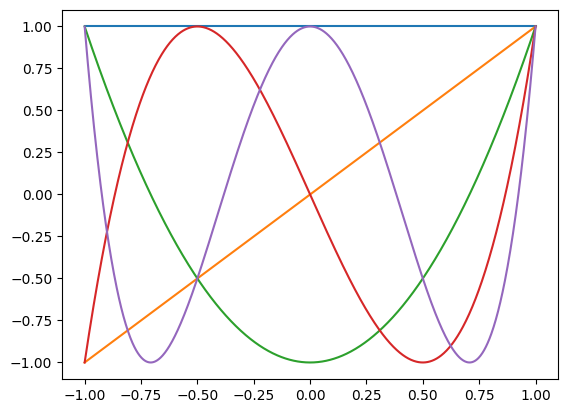

In [124]:
# Chebyshev Polynomials

# Recurrence formula
n = 5
T = np.zeros((2, n))
T[0, 0] = T[1, 1] = 1
for i in range(2, n):
    T = np.r_[T, [2*np.roll(T[-1], 1) - T[-2]]]
    

# Plot
x = np.linspace(-1, 1, 1000)
y = T @ [x**i for i in range(n)]
plt.plot(np.stack([x]*(n)).T, y.T)
plt.show()

In [125]:
xi, w = scipy.special.roots_chebyt(n+1)
xi = [xi**i for i in range(n)]
def inner(Ti, Tj):
    return np.sum((Ti @ xi) * (Tj @ xi) * w, axis=-1)

In [126]:
# Finite element matrix
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(T[i], T[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[ 3.14  0.   -0.    0.    0.  ]
 [ 0.    1.57  0.   -0.    0.  ]
 [-0.    0.    1.57  0.    0.  ]
 [ 0.   -0.    0.    1.57 -0.  ]
 [ 0.    0.    0.   -0.    1.57]]


In [127]:
# Finite element matrix for 1D Poisson equation

T_diff1 = np.roll(np.arange(n) * T, -1) # first derivative
T_diff2 = np.roll(np.arange(n) * T_diff1, -1) # second derivative
A = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = inner(T[i], T_diff2[j])

with np.printoptions(precision=2, suppress=True):
    print(A)

[[  0.     0.    12.57  -0.   100.53]
 [  0.     0.     0.    37.7    0.  ]
 [  0.     0.    -0.     0.    75.4 ]
 [  0.     0.     0.    -0.     0.  ]
 [  0.     0.     0.     0.     0.  ]]


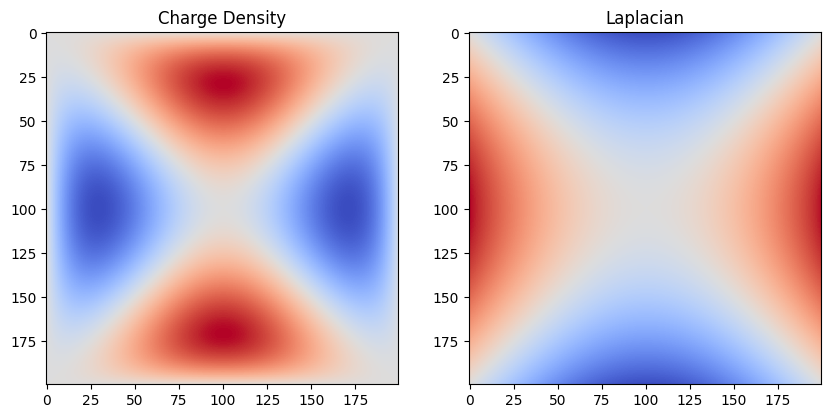

In [146]:
# 2D Poisson Equation

smoothness = 5

"""
Interior
--------

We directly evaluate the n^2 x n^2 inner products

〈Ψy〈Ψx, Φx〉Φy〉=〈Ψx, Φx〉*〈Ψy, Φy〉

as we chose a separable basis.
"""

diff_x = [inner(Ti, Tj) for Ti in T_diff2 for Tj in T]
diff_y = [inner(Ti, Tj) for Ti in T for Tj in T_diff2]
no_diff = [inner(Ti, Tj) for Ti in T for Tj in T]
A = np.outer(no_diff, diff_x) + np.outer(no_diff, diff_y)
b = np.zeros(n**2)

"""
Boundaries
----------

We're putting potentials of +/-1 along the edges. Evaluating at x=-1 gives the left boundary condition:

    1 = Σ〈Ψx(-1)Ψy(y), Φx(-1)Φy(y)''〉= Σ〈Ψy, Φy''〉

as

    Tn(-1) = (-1)^n => Ψx(-1)Φx(-1) = 1.

Similarly,
    
    Σ〈Ψx, Φx〉= -1.

To keep it smooth, we also want the derivatives to evaluate to zero:

    Σ〈Ψx, Φx⁽ᵏ⁾〉= Σ〈Ψy, Φy⁽ᵏ⁾〉= 0, k ≥ 1.

"""

s = smoothness + 1
A = np.pad(A, [(4 * s * n, 0), (0, 0)])
b = np.pad(b, (4 * s * n, 0))

T_diff = T
for k in range(s):
    A_1d = np.zeros((n, n))
    for i in range(n-k):
        A_1d[i, i+k] = inner(T[i], T_diff[i+k])
    
    ones = T_diff @ np.ones(n)
    negs = T_diff @ (-1)**np.arange(n)
    
    # Set derivatives:
    A[(4*k+0)*n:(4*k+1)*n] = np.einsum('ij,k->ijk', A_1d, ones).reshape(n, n**2) # right
    A[(4*k+1)*n:(4*k+2)*n] = np.einsum('ij,k->ijk', A_1d, negs).reshape(n, n**2) # left
    A[(4*k+2)*n:(4*k+3)*n] = np.einsum('ij,k->ikj', A_1d, ones).reshape(n, n**2) # bottom
    A[(4*k+3)*n:(4*k+4)*n] = np.einsum('ij,k->ikj', A_1d, negs).reshape(n, n**2) # top
    
    if k == 2: # Set charges of +/-1 along edges:
        b[(4*k+0)*n:(4*k+1)*n] = inner(T_diff, ones) # right
        b[(4*k+1)*n:(4*k+2)*n] = inner(T_diff, ones) # left
        b[(4*k+2)*n:(4*k+3)*n] = -inner(T_diff, ones) # bottom
        b[(4*k+3)*n:(4*k+4)*n] = -inner(T_diff, ones) # top
    
    T_diff = np.roll(np.arange(n) * T_diff, -1)


# Solve for coefficients
c = np.linalg.lstsq(A, b, rcond=None)[0]
c = c.reshape((n, n))

def u(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    x = np.einsum('ij,jkl->ikl', T, x)
    y = np.einsum('ij,jkl->ikl', T, y)
    return np.einsum('ixy,ij,jxy->xy', x, c, y)

def laplacian(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    dx = np.einsum('ij,jkl->ikl', T_diff2, x)
    dy = np.einsum('ij,jkl->ikl', T_diff2, y)
    x = np.einsum('ij,jkl->ikl', T, x)
    y = np.einsum('ij,jkl->ikl', T, y)
    return np.einsum('ixy,ij,jxy->xy', dx, c, y) + np.einsum('ixy,ij,jxy->xy', x, c, dy)

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Charge Density")
axes[1].set_title("Laplacian")
im0 = axes[0].imshow(u(x, y), cmap="coolwarm")
im1 = axes[1].imshow(laplacian(x, y), cmap="coolwarm")
plt.show()

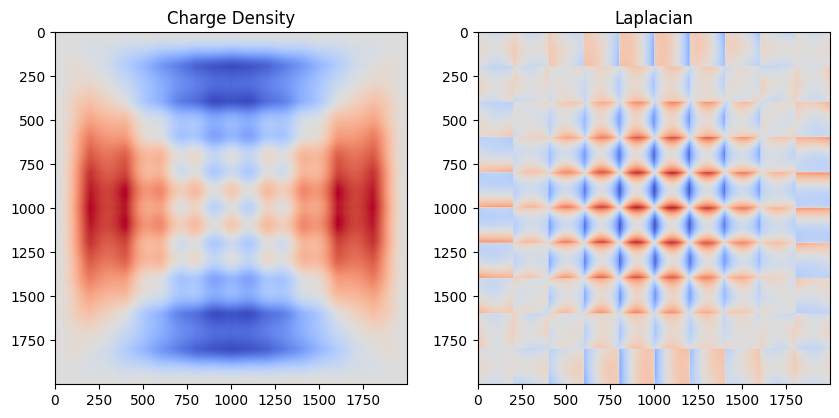

In [161]:
# 2D Poisson Equation, meshed

mesh_size = 10
smoothness = 5

"""
Meshing
-------

We create a mesh_size x mesh_size grid. Between cells we set the derivatives equal.
Indexing becomes a little trickier.
"""

# Interior
diff_x = [inner(Ti, Tj) for Ti in T_diff2 for Tj in T]
diff_y = [inner(Ti, Tj) for Ti in T for Tj in T_diff2]
no_diff = [inner(Ti, Tj) for Ti in T for Tj in T]

m = mesh_size
A = np.outer(no_diff, diff_x) + np.outer(no_diff, diff_y)
A = scipy.linalg.block_diag(*[A for i in range(m**2)])
b = np.zeros(n**2*m**2)


# Boundaries
s = smoothness + 1
A = np.pad(A, [(4 * s * n * m**2, 0), (0, 0)])
b = np.pad(b, (4 * s * n * m**2, 0))

T_diff = T
for k in range(s):
    A_1d = np.zeros((n, n))
    for i in range(n-k):
        A_1d[i, i+k] = inner(T[i], T_diff[i+k])
    
    ones = T_diff @ np.ones(n)
    negs = T_diff @ (-1)**np.arange(n)
    
    # Derivatives:
    right = np.einsum('ij,k->ijk', A_1d, ones).reshape(n, n**2)
    left = np.einsum('ij,k->ijk', A_1d, negs).reshape(n, n**2)
    bottom = np.einsum('ij,k->ikj', A_1d, ones).reshape(n, n**2)
    top = np.einsum('ij,k->ikj', A_1d, negs).reshape(n, n**2)
    
    for x in range(m):
        for y in range(m):
            i = 4*k*n + 4*n*s*(x+y*m)
            j = n**2*(x+y*m)
            
            # right boundary
            A[i:i+n, j:j+n**2] = right
            if x < m-1:
                A[i:i+n, j+n**2:j+2*n**2] = -left
            elif k == 2:
                # Set very right-most boundary charge
                b[i:i+n] = inner(T_diff, ones)
                
            # left boundary
            i += n
            A[i:i+n, j:j+n**2] = left
            if x > 0:
                A[i:i+n, j-n**2:j] = -right
            elif k == 2:
                # Set very left-most boundary charge
                b[i:i+n] = inner(T_diff, ones)
                
            # bottom boundary
            i += n
            A[i:i+n, j:j+n**2] = bottom
            if y < m-1:
                A[i:i+n, j+m*n**2:j+(m+1)*n**2] = -top
            elif k == 2:
                # Set very bottom-most boundary charge
                b[i:i+n] = -inner(T_diff, ones)
            
            # top boundary
            i += n
            A[i:i+n, j:j+n**2] = top
            if y > 0:
                A[i:i+n, j-m*n**2:j-(m-1)*n**2] = -bottom
            elif k == 2:
                # Set very top-most boundary charge
                b[i:i+n] = -inner(T_diff, ones)
    
    T_diff = np.roll(np.arange(n) * T_diff, -1)

# Solve for coefficients
c = np.linalg.lstsq(A, b, rcond=None)[0]
c = c.reshape((m, m, n, n))

def u(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    x = np.einsum('ij,jkl->ikl', T, x)
    y = np.einsum('ij,jkl->ikl', T, y)
    
    t = []
    for a in range(m):
        t += [[]]
        for b in range(m):
            t[-1] += [np.einsum('ixy,ij,jxy->xy', x, c[a, b], y)]
        t[-1] = np.hstack(t[-1])
    t = np.vstack(t)
    return t

def laplacian(x, y):
    x = np.array([x**i for i in range(n)])
    y = np.array([y**i for i in range(n)])
    dx = np.einsum('ij,jkl->ikl', T_diff2, x)
    dy = np.einsum('ij,jkl->ikl', T_diff2, y)
    x = np.einsum('ij,jkl->ikl', T, x)
    y = np.einsum('ij,jkl->ikl', T, y)
    
    t = []
    for b in range(m):
        t += [[]]
        for a in range(m):
            t[-1] += [np.einsum('ixy,ij,jxy->xy', dx, c[a, b], y) + \
                      np.einsum('ixy,ij,jxy->xy', x, c[a, b], dy)]
        t[-1] = np.hstack(t[-1])
    t = np.vstack(t)
    return t

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Charge Density")
axes[1].set_title("Laplacian")

im0 = axes[0].imshow(u(x, y), cmap="coolwarm")
im1 = axes[1].imshow(laplacian(x, y), cmap="coolwarm")
plt.show()

In [172]:
# Fast Fourier Transform
# see https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm

def fft(x, inverse=False):
    if bin(len(x)).count('1') > 1:
        raise "You must pad x so the number of elements is a power of two."
    
    N = len(x)
    if N == 1:
        return x
    
    w = np.exp(-2j*np.pi/N) ** np.arange(N//2)
    if inverse:
        w = w.conj()
    
    y = fft(x[::2], inverse=inverse)
    z = fft(x[1::2], inverse=inverse)
    return np.r_[y + w * z, y - w * z]

ifft = lambda x: fft(x, inverse=True) / len(x)

# Multiply two polynomials together.

a = np.array([1, 1, 1, 1, 0, 0, 0, 0]) # 1 + x + x^2 + x^3
b = np.array([1, 2, 3, 4, 0, 0, 0, 0]) # 1 + 2x + 3x^2 + 4x^3
c = ifft(fft(a) * fft(b)).real

with np.printoptions(precision=2, suppress=True):
    print("a(x)        = 1x^0 + 1x^1 + 1x^2 + 1x^3")
    print("b(x)        = 1x^0 + 2x^1 + 3x^2 + 4x^3")
    print("a(x) * b(x) =", " + ".join(f"{c:.0f}x^{i}" for i, c in enumerate(c)))

a(x)        = 1x^0 + 1x^1 + 1x^2 + 1x^3
b(x)        = 1x^0 + 2x^1 + 3x^2 + 4x^3
a(x) * b(x) = 1x^0 + 3x^1 + 6x^2 + 10x^3 + 9x^4 + 7x^5 + 4x^6 + 0x^7


In [173]:
np.r_[[1, 2], [3, 4]]

array([1, 2, 3, 4])

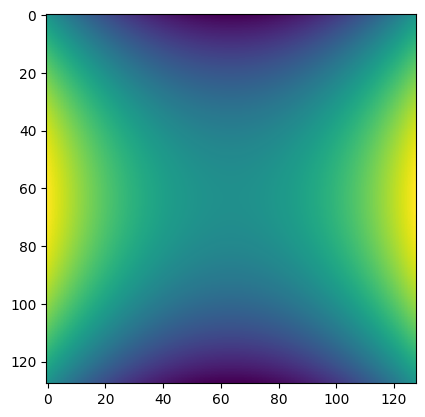

In [216]:
from scipy.fft import dctn, idctn

# Reference:
# https://elonen.iki.fi/code/misc-notes/neumann-cosine/
def solve_poisson(f):
    nx, ny = f.shape

    # Transform to DCT space
    dct = dctn(f, type=1)

    # Divide by magical factors
    cx = np.cos(np.pi * np.arange(nx) / (nx - 1))
    cy = np.cos(np.pi * np.arange(ny) / (ny - 1))
    c = np.add.outer(cx, cy) - 2

    np.divide(dct, c, out=dct, where=c != 0)
    dct[c == 0] = 0

    # Return to normal space
    potential = idctn(dct, type=1)
    return potential / 2

N = 128
x = np.zeros((N, N))
x[0, :] = x[-1, :] = 1
x[:, 0] = x[:, -1] = -1

plt.imshow(solve_poisson(x))